<a href="https://colab.research.google.com/github/karencfisher/hotel-reviews/blob/main/notebooks/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.python.keras.utils.version_utils import TensorBoardVersionSelector
import pandas as pd
import numpy as np
import re
import datetime
import nltk
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_reviews = pd.read_csv('/content/drive/MyDrive/hotel_reviews/reviews.csv')
df_reviews.head()

,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Title,Content,Date,ReviewID
0,5,5,5,5,5,5,5,“Super stay.”,This the second time we have stayed and this t...,"April 20, 2012",UR128207934
1,5,5,4,4,5,5,4,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,"April 11, 2012",UR127662460
2,5,5,5,4,5,4,4,“span pacific orchard”,Great hotel in good location for night life & ...,"April 11, 2012",UR127648467
3,5,5,5,4,5,5,4,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,"April 6, 2012",UR127365749
4,5,4,5,5,4,5,4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...","April 2, 2012",UR127143142


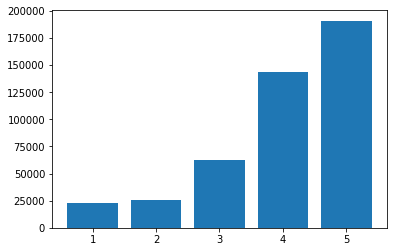

In [6]:
plt.bar([1, 2, 3, 4, 5], df_reviews['Overall'].value_counts().sort_index());

### Baseline using Overall column as targets. 

Accuracy just randomly guessing the class for an example

In [9]:
n_classes = df_reviews['Overall'].value_counts().values
n = df_reviews.shape[0]
baseline = np.sum((n_classes / n) ** 2)
print(f'Baseline accuracy: {baseline * 100: .2f}%')

Baseline accuracy:  31.42%


In [10]:
# Drop date and reviewID columns
df_reviews.drop(columns=['Date', 'ReviewID'], inplace=True)

# Add column for average score (averaging ratings for each review)
cols = df_reviews.columns[:7]
df_reviews['average_score'] = df_reviews[cols].mean(axis=1)

# Drop individual category ratings
df_reviews.drop(columns=cols, inplace=True)

In [11]:
df_reviews.head()

,Title,Content,average_score
0,“Super stay.”,This the second time we have stayed and this t...,5.000000
1,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,4.571429
2,“span pacific orchard”,Great hotel in good location for night life & ...,4.571429
3,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,4.714286
4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...",4.571429


### Distrubution of average scores

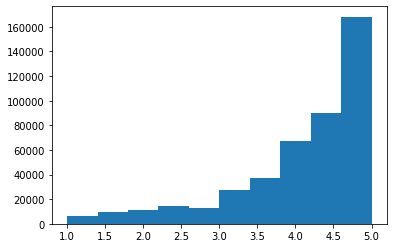

In [12]:
plt.hist(df_reviews['average_score'], bins=10);

### Approximate baseline accuracy

Guessing randomly of 10 classes accross distribution of average_scores

In [23]:
counts = np.histogram(df_reviews['average_score'], bins=10)[0]
n = df_reviews.shape[0]
baseline = np.sum((counts / n) ** 2)
print(f'Aporiximate baseline accuracy: {baseline * 100: .2f}%')

Aporiximate baseline accuracy:  22.13%


### Sample titles and descriptions by average score

In [18]:
import textwrap

wrapper = textwrap.TextWrapper(width=140)
for i in range(1, 6):
  print(f'Average Score: {i}')
  cond = df_reviews['average_score'].astype(int) == i
  df_sample = df_reviews[cond].sample(10).sort_values(by='average_score')
  for row in range(len(df_sample)):
    print(df_sample.iloc[row]['Title'], '\n', f'Score = {df_sample.iloc[row]["average_score"]: .2f}')
    text = wrapper.wrap(df_sample.iloc[row]['Content'])
    for w in text:
      print(w)
    print('\n')
  print('*************\n')

Average Score: 1
“you get what you pay for” 
 Score =  1.00
I booked in for 1 night because of a doctor's appointment the next day and stayed an extra night, out of necessity, for further tests and I
was just too tired to look for another hotel - the rooms are shaby and run down and not too clean - the 1st room I was given was ok size
wise but so cold I had to move to a much small room that was warmer, but not because of the better heat - but because there was only 1
window - and this room was the same price as the other larger one - for the freezing cold weather that we had they were very stingy with the
heat and you can't control it yourself - its an old fashion radiator that you can't adjust at all even though it had knobs that you should
have been able to turn for more heat. This is one hotel I'll never stay in again - gave me a Hilton any day - you get what you pay for - I
was also charged a d Javits tax on c/o and never given an explaintion for it - what a rip off.


“Never Again

### Bucketize reviews into two sentiments, Good vs. Bad

Threshold = average score 3.5

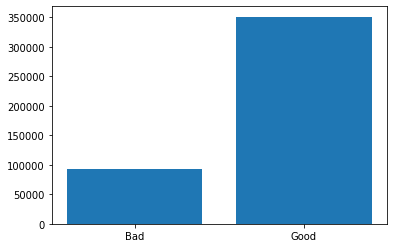

In [19]:
df_reviews['sentiment'] = df_reviews['average_score'].apply(lambda x: 1 if x >= 3.5 else 0)
plt.bar(['Bad', 'Good'], df_reviews['sentiment'].value_counts().sort_index());

### Calculate a baseline accuracy

Randomly guessing 0 or 1 for each example

In [20]:
num_classes = df_reviews['sentiment'].value_counts().values
n = df_reviews.shape[0]
baseline = np.sum((num_classes / n) ** 2)
print(f'Baseline accuracy: {baseline * 100: .2f}%')


Baseline accuracy:  66.89%


In [21]:
nltk.download(['names', 'stopwords'])
stopwords = nltk.corpus.stopwords.words("english")

def cleanText(document):
  text = re.sub('[^a-zA-Z0-9 ]', '', document)
  tokens = text.lower().split()
  tokens = [w for w in tokens if w not in stopwords]
  return " ".join(tokens)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
df_reviews['Title'] = df_reviews['Title'].apply(lambda x: x.replace('“','').replace('”',''))
df_reviews['Content'] = df_reviews['Title'] + ' ' + df_reviews['Content']
df_reviews.drop(columns=['Title'], inplace = True)
df_reviews['Content'] = df_reviews['Content'].apply(cleanText)
df_reviews.sample(10)


,Content,average_score,sentiment
225436,loved would love back 2011 wow great place sta...,5.000000,1
169517,w letdown youre looking hotel conveniently loc...,2.000000,0
368878,stay stayed week april room clean comfortable ...,4.428571,1
299417,novotel sydney stay hotel nicely situated darl...,4.142857,1
150455,lovely hotel shame location booked room 2 adul...,4.428571,1
407936,reason keep coming back everytime go side la r...,5.000000,1
304161,airport downtown free airport shuttle local pu...,3.571429,1
181183,second time good stayed signature week christm...,5.000000,1
192676,fantastic location godd pricevalue spent 2 nig...,4.142857,1
183657,tired rooms love sofitel hotels first time sta...,3.285714,0
